#Classification par regression logistique des images MNIST

On va entraîner un réseau de neurones à classer des chiffres écrits à la main à partir de l'ensemble de données MNIST classique. En utilisant les réseaux de neuronnes déjà fourni par l'api tensorflow

On va ensuite visualiser les pondérations d'une couche cachée de réseau de neurones

Commençons par importer nos librairies et nos données 

In [45]:

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

# Eviter de print tous les warnings et les erreurs 
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Option d'affichage des données contenues dans le dataframe 
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",sep=",",header=None)

print(len(mnist_dataframe))

# L'ensemble contient envion 20000 exemples mais nous allons seulement utiliser 10000
mnist_dataframe = mnist_dataframe.head(10000)

# On vient melanger les donnees aleatoirement pour homogéneiser l'ensemble et eviter les biais
mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))

# On regarde un peu à quoi ça correspond pour mieux visualiser les données

mnist_dataframe.head()

20000


,0,1,2,3,4,5,6,...,778,779,780,781,782,783,784
5315,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0
4226,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
8376,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0
8766,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0
5154,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0


Comme on peut le constater, la première colonne contient l'étiquette de classe. C'est à dire le nombre contenu dans l'image.

 Les autres colonnes contiennent les valeurs de caractéristique, autrement dit valeurs de chaque pixel de l'image. Les images sont carrées de taille 28×28 pixels soit un total de 784 pixels. 
 
Ainsi, chaque image se retrouve sous la forme d'un vecteur ligne de 784 composantes qui prennent la veleur numerique du niveau de gris qu'elle représente. Comme l'image est constituée à majorité de blanc, il est normal de retrouver une majorite de pixel à 0.

Chacun des dix chiffres 0-9 est représenté avec une étiquette de classe unique. Il s'agit donc d'un problème de classification à classes multiples avec 10 classes.



In [46]:
# Creation de la fonction qui va formater les donner et diviser les features cad les valeurs des pixels des labels 
# et renvoyer les labels dans une séries et les features dans un dataframe 

def traitement_labels_and_features(dataset):
  # On selection la premiere colonne qui contient les labels et on l'isole
  labels = dataset[0] 

  #On va selectionner les pixels d'un autre coté mais on a 784 colonnes numerotés
  # Pour les selectionner on va utiliser loc pour les traiter comme des index de colonnes 
  # On selectionne toutes les lignes, sur les colonnes de 1 à 784 compris
  features = dataset.loc[:,1:784]

  # Les pixels representent des valeurs des gris/noir. Cela etant codé sur un octet, on a 256 niveaux de couleurs (0-255)
  # On va diviser alors les valeurs des pixels par la valeur max 255 afin d'avoir des valeurs comprises entre 0 et 1
  
  features = features / 255


  # On retourne en premier argument les labels et dans un second argument les features
  return labels, features


On crée les ensembles d'entrainement et de validation :



In [47]:
# Création de l'ensemble d'entrainement et des labels d'entrainement
# On selection 7500 exemples pour l'apprentissage
training_targets, training_examples = traitement_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()


,1,2,3,4,5,6,7,...,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,1.0,0.2,0.0,0.0,0.0,0.0


In [48]:
# Création de l'ensemble de validation et des labels de validation. On selectionne seulement 2500 pour la validation
validation_targets, validation_examples = traitement_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,...,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pour verifier que tout se passe bien on va plotter une image prise aléatoirement 

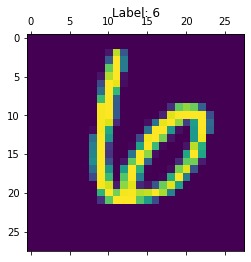

In [49]:
# Selection exemple :
example = np.random.choice(training_examples.index)

# Plot de l'image 
_, ax = plt.subplots()
ax.matshow(training_examples.loc[example].values.reshape(28, 28))
# La fonction reshape est utiliser pour redonner une forme carrée à l'image 
ax.set_title("Label: %i" % training_targets.loc[example])
ax.grid(False)

Création de la fonction qui creer la tableau de description des features 


In [50]:
def construct_feature_columns():  
  # There are 784 pixels in each image. 

  return set([tf.feature_column.numeric_column('pixels', shape=784)])
# Cette fonction indique a tensorflow qu'on a un seul type de feature qui est s'appelle pixels, qui sont de type nombre et qui ont une taille de 784 

# Test fonction 
print(len(construct_feature_columns()))

1


Création de la fonction qui va creer les ensembles formatés et découpés en bach ( features+ labels ) 

On va créer des fonctions d'entrée distinctes pour l'apprentissage et la prédiction.

On va les imbriquer dans create_training_input_fn() et create_predict_input_fn(), respectivement, afin de pouvoir les invoquer pour renvoyer les fonctions _input_fn correspondantes qui doivent être transmises aux appels .train() et .predict().


In [51]:
# Cette fonction est reservée au données d'entrainement , pour construire le data set et former les batch
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """
    
    Arguments:
    features: Les features destinées à l'entrainement .
    labels: Les labels associés aux features d'entrainement .
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  # Cette fonction contient alors la fonction  _input_fn() qui herite des arguments de la fonctions mère

  def _input_fn(num_epochs=None, shuffle=True):

    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object

    # On vient melanger à chaque fois l'ensemble de données donné
    idx = np.random.permutation(features.index)

    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
  #  Après aboie été mélangés ont les associes pour diviser l'ensemble des données en sous ensembles plus petits
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Renvoie le batch de données suivant
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()

    return feature_batch, label_batch

  return _input_fn
 

In [52]:
# Cette fonction est reservée au données à predire , pour construire le data set et former les batch
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: les features sur lequels on va faire nos predictions
    labels: les labels associés à ces features .

  Returns:
    Retourne les features les labels pour la prediction .

  """
  # Elle hérite des arguments de la fonction mère : Elle realise les memes actions que la fonction précedente
  def _input_fn():

    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()

    return feature_batch, label_batch

  return _input_fn

  

On v a créer maintenant le fonction qui va se charge d'integrer tous les donnees et d'entrainer le model 



In [53]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained model object.
  """

  periods = 10

  steps_per_period = steps / periods  

  # On crée les dataset de prediction et de validation :
  predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)

  # On creer le dataset qui va servir à entrainer le modèle
  training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
  
  # Création du modèle avec son optimiseur 
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  # Le paramètre n_classes represente le sombre de neurones contenues dans la couche softmax et donc le nombre de classes à detecter
  classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(),
      n_classes=10,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # On entraine le modèle .
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # On stop l'apprentissage et on vient tester le modèle et on calcule les probabilité d'appartenance
    # On convertit le format des prediction en listes
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    # On vient stocker les probabilités dans une tableau et les id des classes dans un autre
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    # On vient classer les elements dans un vecteur one-hot
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    # idem pour l'ensemble de validation 
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)   
    print(validation_pred_one_hot) 
    
    # On calcule les erreurs d'entrainement et les erreurs de validation avec la fonction de cout Logloss
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)

    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)

  # Fin de l'apprentissage
  print("Model training finished.")

  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])

  print(final_predictions)
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # On print une matrice de confusion afin de savoir combien d'elements on bien été classée et combien on mal été classés 
  cm = metrics.confusion_matrix(validation_targets, final_predictions)


  # On va normaliser cette matrice par ligne (i.e by the number of samples in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

On lance l'entrainement du modèle:




Training model...
LogLoss error (on validation data):
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
  period 00 : 6.77
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
  period 01 : 3.87
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
  period 02 : 2.92
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
  period 03 : 3.03
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
  period 04 : 2.54
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 

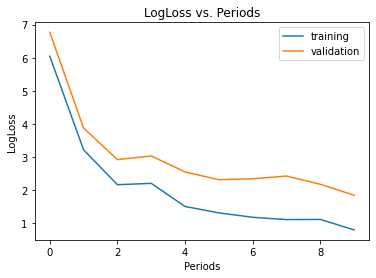

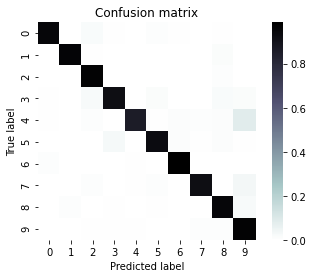

In [54]:
classifier = train_classification_model(
    learning_rate=0.05,
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Vérifions que l'ensemble de validation n'a pas été surappris en évaluant les données de test.

In [56]:
# Chargement des données Test
mnist_test_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
  sep=",",
  header=None)

# Traitement des données et séparation :
test_targets, test_examples = traitement_labels_and_features(mnist_test_dataframe)
test_examples.describe()


,1,2,3,4,5,6,7,...,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Creation du dataset de test
predict_test_input_fn = create_predict_input_fn(test_examples, test_targets, batch_size=100)

# Utilisation du modèle entrainé pour prédire 
test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])

# Calcule de la justesse 
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

Accuracy on test data: 0.94


On va explorer le réseau de neurones pour savoir ce qu'il a appris. 

Pour cela, on va accéder à l'attribut weights_ du modèle.

La couche d'entrée du modèle compte 784 pondérations correspondant aux images d'entrée 28×28. La première couche cachée aura 784×N pondérations, où N représente le nombre de nœuds de cette couche. 



['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


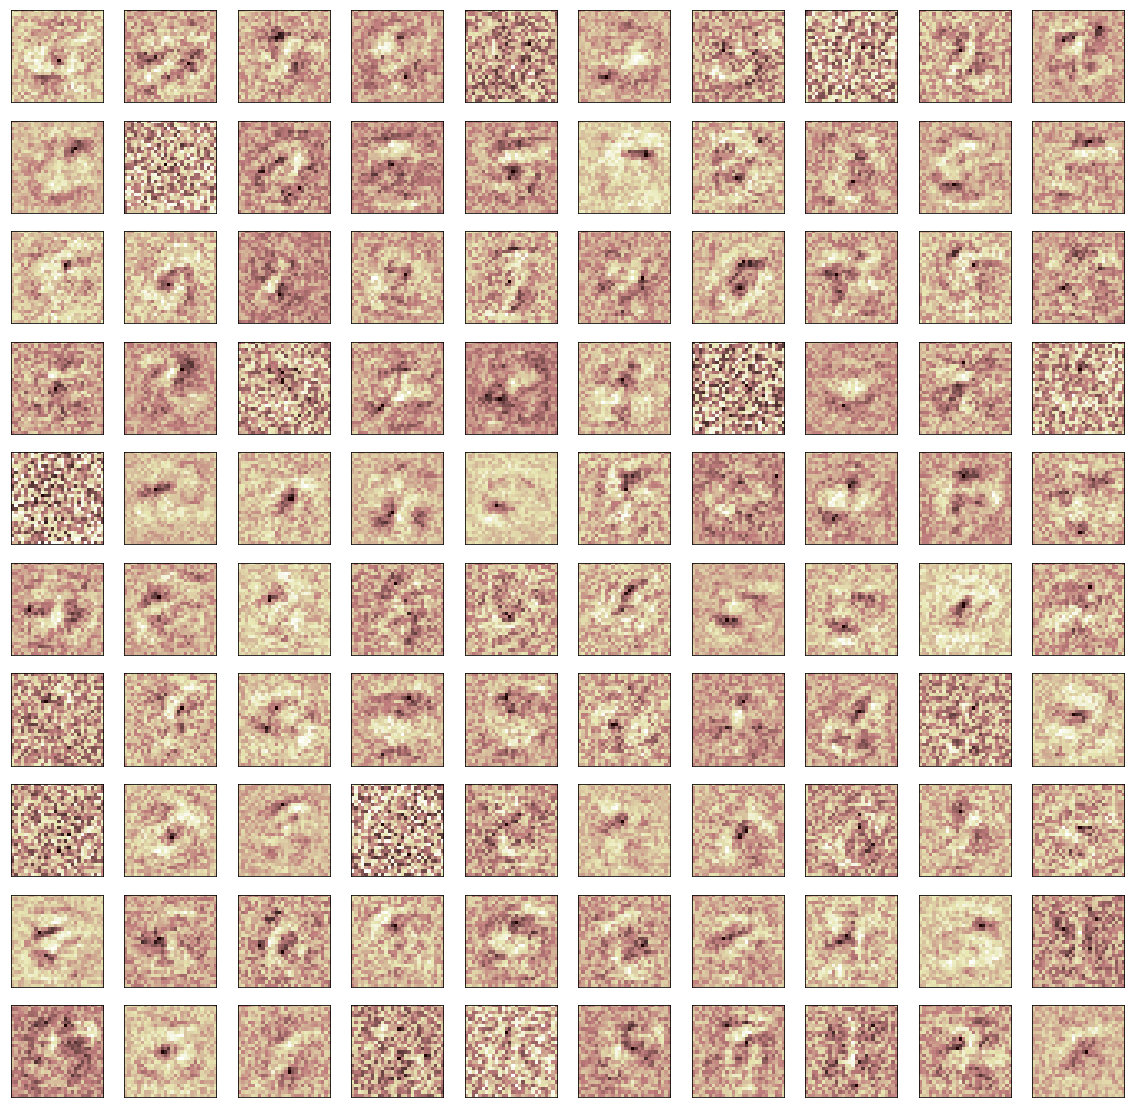

In [58]:
# Modèle entrainé
print(classifier.get_variable_names())

weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()